# Training dynamics
This notebook monitors the training / validation losses of each of two DENVIS models (trained on PDBBind general and refined sets) during training of a single model.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import tensorboard as tb

In [2]:
EXPERIMENT_ID = "WYWAlNUJR3Gt6monPvHPhw"

In [3]:
def convert_df(df):
    """Helper function to convert DataFrame to tidy-format.
    Following this approach:
    https://stackoverflow.com/a/17496530
    """
    rows_list = []
    for row in df.iterrows():
        train_dset, model, _, version = row[1]['run'].split('/')
        if train_dset == 'general':
            train_dset = 'DENVIS-G'
        elif train_dset == 'refined':
            train_dset = 'DENVIS-R'
        else:
            raise ValueError(f'Found trainining dataset {train_dset}.')

        if model == 'atom_level':
            model = 'Atom-level'
        elif model == 'surface_level':
            model = 'Surface-level'
        elif model == 'ligand_baseline':
            model = 'Ligand baseline'
        else:
            raise ValueError(f'Found model {model}.')

        version = version.split('_')[1]
        step = row[1]['step']
        loss = row[1]['value']
        metric = row[1]['tag'].split('/')[0]
        
        if metric == 'train':
            metric = 'Training loss'
        elif metric == 'val':
            metric = 'Validation loss'
        else:
            raise ValueError(f'Found metric {metric}.')

        rows_list.append({
            'Training dataset': train_dset,
            'Model': model,
            'Version': int(version),
            'Metric': metric,
            'Step': int(step),
            'Loss': float(loss)
        })
    return pd.DataFrame(rows_list)


In [4]:
experiment = tb.data.experimental.ExperimentFromDev(EXPERIMENT_ID)
df = experiment.get_scalars()
loss_df = df[df['tag'].isin(['train/loss_epoch', 'val/loss'])]
loss_df_tf = convert_df(loss_df)

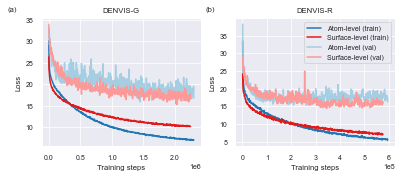

In [5]:
figsize = (5.5,2.5)
sharex = False
sharey = False
font_scale = 0.8
lw = 1.5
out_path = '/nfs-data/a.krasoulis/pharma/vs_manuscript/figures/train_val_losses.pdf'

sns.set_context("paper", font_scale=font_scale, rc={"lines.linewidth": lw})
fig, ax = plt.subplots(figsize=figsize, sharex=sharex, sharey=sharey, nrows=1, ncols=2)
palette = sns.color_palette("Paired", 6)
color = {'Atom-level-val': palette[0], 'Atom-level-train': palette[1], 'Surface-level-val': palette[4], 'Surface-level-train': palette[5]}
lstyle = {'Training loss': '-', 'Validation loss': '--'}
for m, train_set in enumerate(['DENVIS-G', 'DENVIS-R']):
    for metric, metric_name in zip(['Training loss', 'Validation loss'], ['train', 'val']):
         for model in ['Atom-level', 'Surface-level']:   
            slice_ = loss_df_tf[
                (loss_df_tf['Training dataset'] == train_set) &
                (loss_df_tf['Model'] == model) &
                (loss_df_tf['Version'] == 0) &
                (loss_df_tf['Metric'] == metric)
                ]
            ax[m].plot(slice_['Step'], slice_['Loss'],
                          label=f'{model} ({metric_name})', c=color[f'{model}-{metric_name}'])
            ax[m].set_title(f'{train_set}')
            ax[m].set_xlabel('Training steps')
            ax[m].set_ylabel('Loss')
            ax[m].ticklabel_format(axis='x', style='sci', scilimits=(0,0))
ax[1].legend()
fig.text(0, 0.93, '(a)')
fig.text(0.5, 0.93, '(b)')
fig.tight_layout()
plt.show()